<a href="https://colab.research.google.com/github/KacperKurzydlo/UdzialBadaniaNaukowe/blob/main/Sie%C4%87_v7_Tanh%26MnijeszaDziura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import laplace
from scipy.integrate import solve_bvp

import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras import Input, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Reshape
import datetime

In [13]:
from numba import njit

@njit
def laplace_2d_converge(u, nx, ny, hs, maxiter, tol=1e-6):
    """
    Solves the 2D Laplace equation using the Jacobi method with convergence checking,
    and applies boundary conditions with a fixed zero potential at the center of the domain.
    """
    for iteration in range(maxiter):
        u_old = u.copy()

        # Vectorized update for interior points
        u[1:-1, 1:-1] = 0.25 * (
            u_old[2:, 1:-1] +  # u[i+1, j]
            u_old[:-2, 1:-1] +  # u[i-1, j]
            u_old[1:-1, 2:] +  # u[i, j+1]
            u_old[1:-1, :-2]   # u[i, j-1]
        )

        center_x, center_y = nx // 2, ny // 2
        half_size = hs

        u[center_y - half_size:center_y + half_size + 1, center_x - half_size:center_x + half_size + 1] = 0.0

        # Check for convergence
        max_change = np.max(np.abs(u - u_old))
        if max_change < tol:
            break

    return u

# Define the domain and boundary conditions
nx, ny = 100, 100
x, y = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
dx, dy = 1 / (nx - 1), 1 / (ny - 1)

N = 1000

train_set = np.zeros([N, nx, ny])
labels_train = np.zeros([N, 5])

for i in range(N):

    # Initial guess
    u = np.zeros((ny, nx))

    t = np.random.uniform(0, 1)
    b = np.random.uniform(0, 1)
    l = np.random.uniform(0, 1)
    r = np.random.uniform(0, 1)

    hole_size = int(np.random.uniform(10, 20)) # Size of the hole in the middle x2

    # Boundary conditions (Dirichlet)
    u[0, :] = t  # Top boundary
    u[-1, :] = b  # Bottom boundary
    u[:, 0] = l  # Left boundary
    u[:, -1] = r  # Right boundary

    labels_train[i][0] = t
    labels_train[i][1] = b
    labels_train[i][2] = l
    labels_train[i][3] = r
    labels_train[i][4] = hole_size

    # Solve the Laplace equation
    u = laplace_2d_converge(u, nx, ny, hole_size, maxiter=100000, tol=1e-6)

    train_set[i] = u
    if i % 100 == 0:
        print(f"Iteration {i}/{N}")



Iteration 0/1000
Iteration 100/1000
Iteration 200/1000
Iteration 300/1000
Iteration 400/1000
Iteration 500/1000
Iteration 600/1000
Iteration 700/1000
Iteration 800/1000
Iteration 900/1000


In [14]:
u_train_reshaped = train_set[:N-100]
u_test_reshaped = train_set[N-100:]

labels_train_reshaped  = labels_train[:N-100].reshape(-1, 5)
labels_test_reshaped  = labels_train[N-100:].reshape(-1, 5)

In [15]:
initializer1 = tensorflow.keras.initializers.HeNormal()
initializer2 = tensorflow.keras.initializers.GlorotUniform()

In [34]:
input_shape = (5,)
network = Sequential()

network.add(Dense(64, activation='relu', input_shape=input_shape))
network.add(Dense(128, activation='relu'))

network.add(Dense(256, activation='relu'))
network.add(Dense(512, activation='relu'))

network.add(Dense(128, activation='tanh'))
network.add(Dense(256, activation='tanh'))


network.add(Dense(nx * ny, activation='linear'))
network.add(Reshape((nx, ny)))

network.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 64)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 10000)               │       2,570,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 100, 100)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,842,000 (10.84 MB)

 Trainable params: 2,842,000 (10.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [35]:
from tensorflow.keras.optimizers import Adam

opt = Adam()
network.compile(optimizer='Adam', loss='mse', metrics = ['accuracy'])

In [36]:
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.001, patience = 20, verbose =1)
model_cp = ModelCheckpoint(filepath = 'best_model1.keras', monitor = 'val_accuracy', save_best_only = True, verbose = 1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1, factor=0.5, min_lr=0.00001)

In [37]:
history = network.fit(labels_train_reshaped,
                      u_train_reshaped,
                      validation_data = (labels_test_reshaped, u_test_reshaped),
                      steps_per_epoch = 50,
                      validation_steps = 50,
                      epochs=100,
                      callbacks=[es, model_cp, learning_rate_reduction])

Epoch 1/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0921 - loss: 0.0707
Epoch 1: val_accuracy improved from -inf to 0.24070, saving model to best_model1.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.0942 - loss: 0.0698 - val_accuracy: 0.2407 - val_loss: 0.0352 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss

Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2467 - loss: 0.0342
Epoch 3: val_accuracy did not improve from 0.24070
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.2472 - loss: 0.0342 - val_accuracy: 0.2227 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2604 - loss: 0.0284
Epoch 5: val_accuracy improved from 0.24070 to 0.32480, saving model to best_model1.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.2615 - loss: 0.0284 - val_accuracy: 0.3248 - val_loss: 0.0157 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3949 - loss: 0.0151
Epoch 7: val_accuracy improved from 0.32480 to 0.59180, saving model to best_model1.ke

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

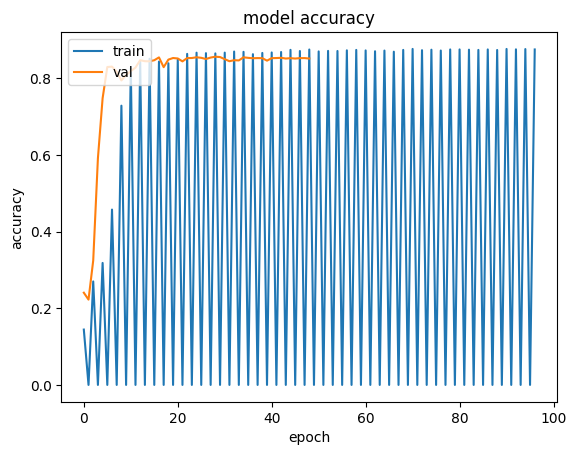

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

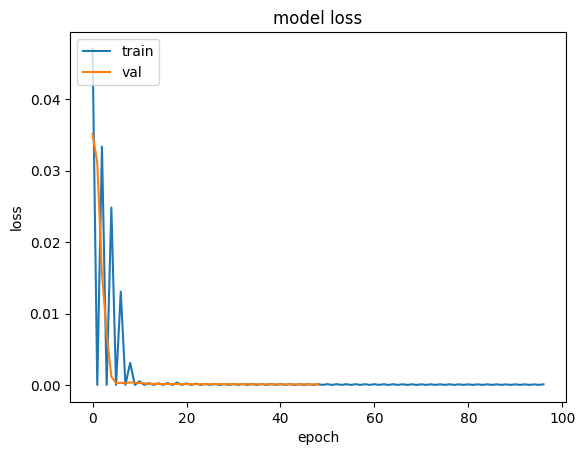

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
from tensorflow.keras.models import load_model
model = load_model('/content/best_model1.keras')

In [ ]:
# pred_image = network.predict(np.array([0.1, 0.2, 0.3, 0.4]).reshape(1, 4))[0]
# plt.pcolormesh(pred_image, cmap='hot')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Mean Squared Error between Laplace solution and neural network prediction: 2.7695e-05


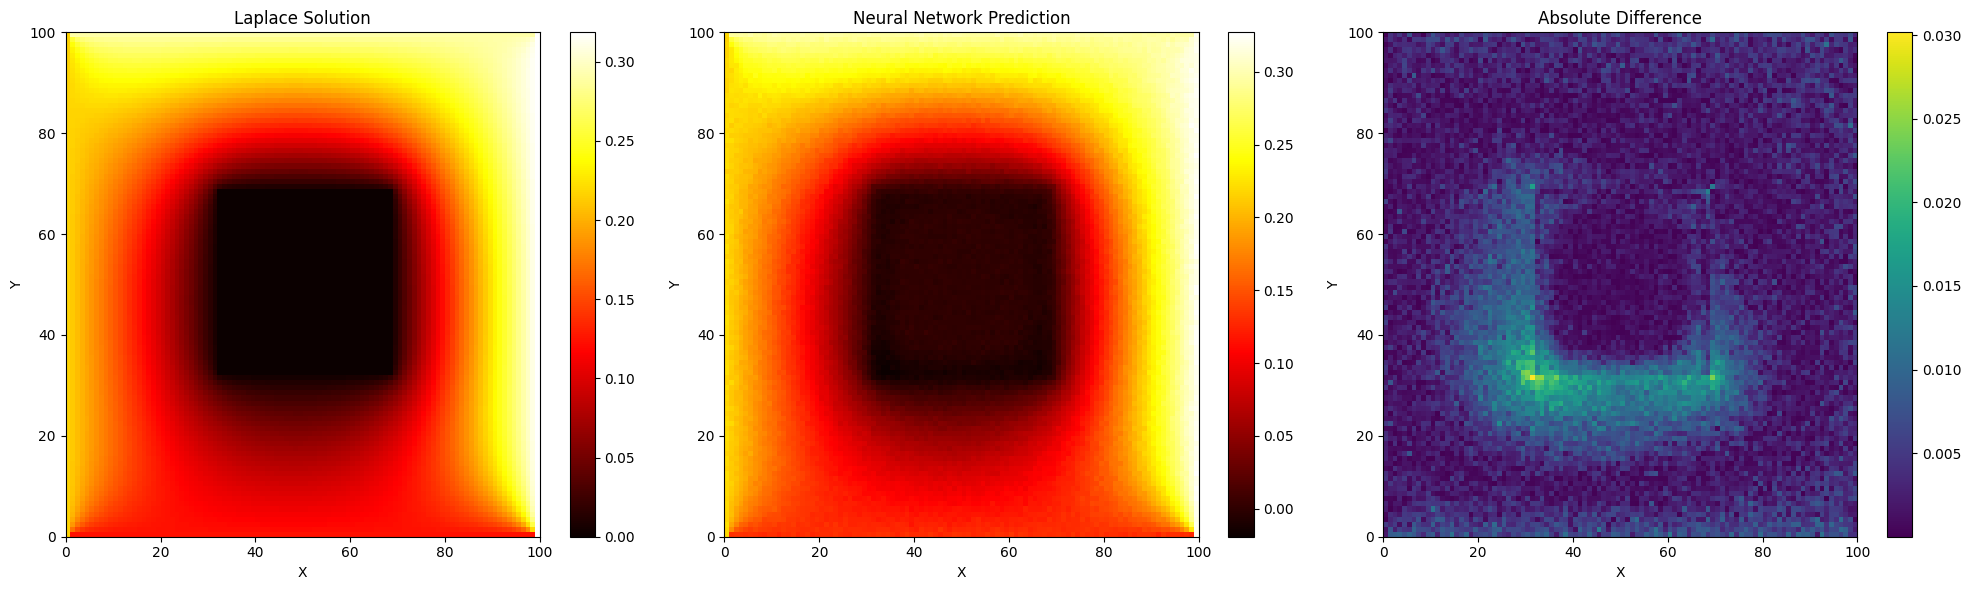

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Mean Squared Error between Laplace solution and neural network prediction: 5.7771e-05


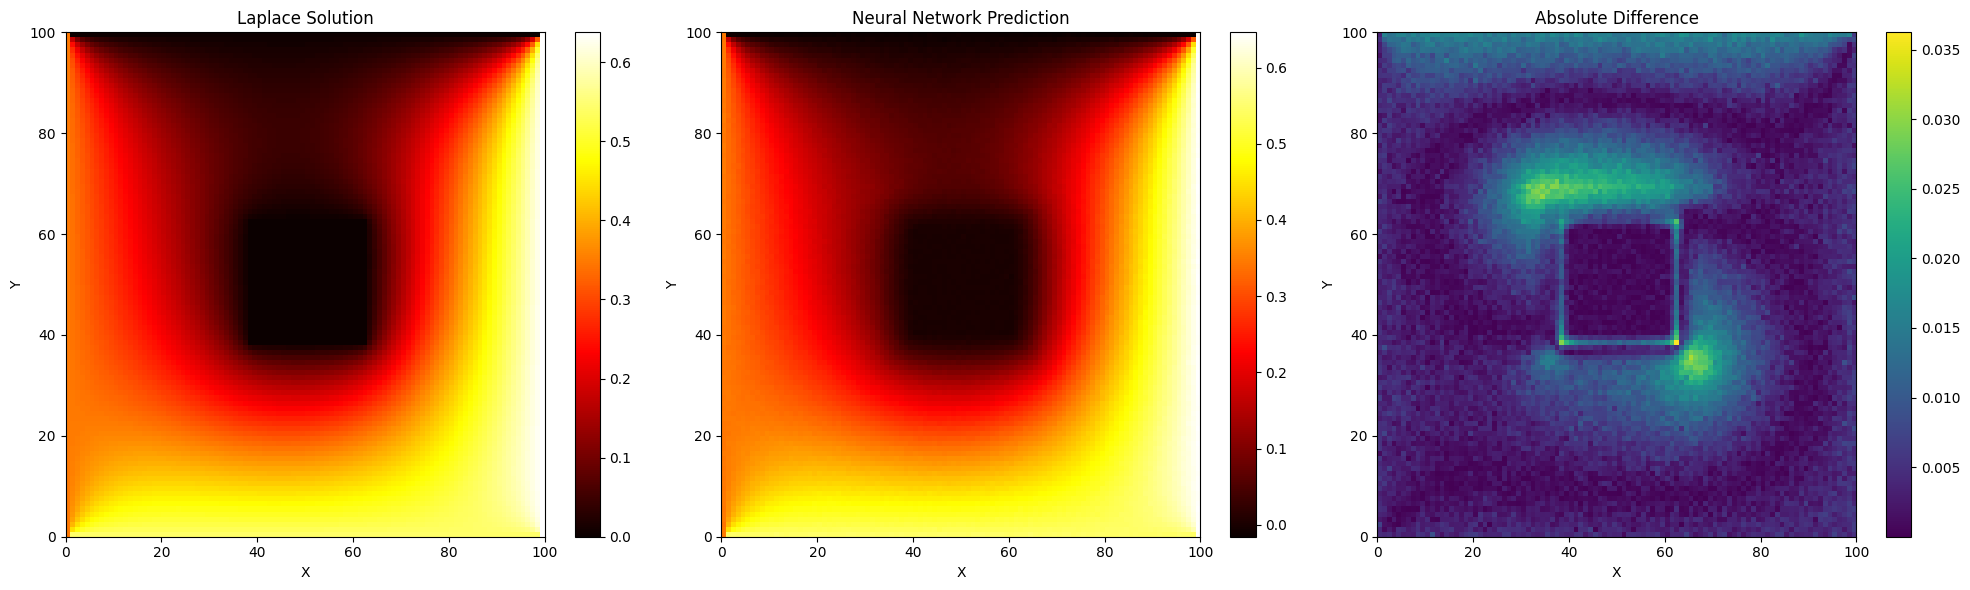

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Mean Squared Error between Laplace solution and neural network prediction: 1.5788e-04


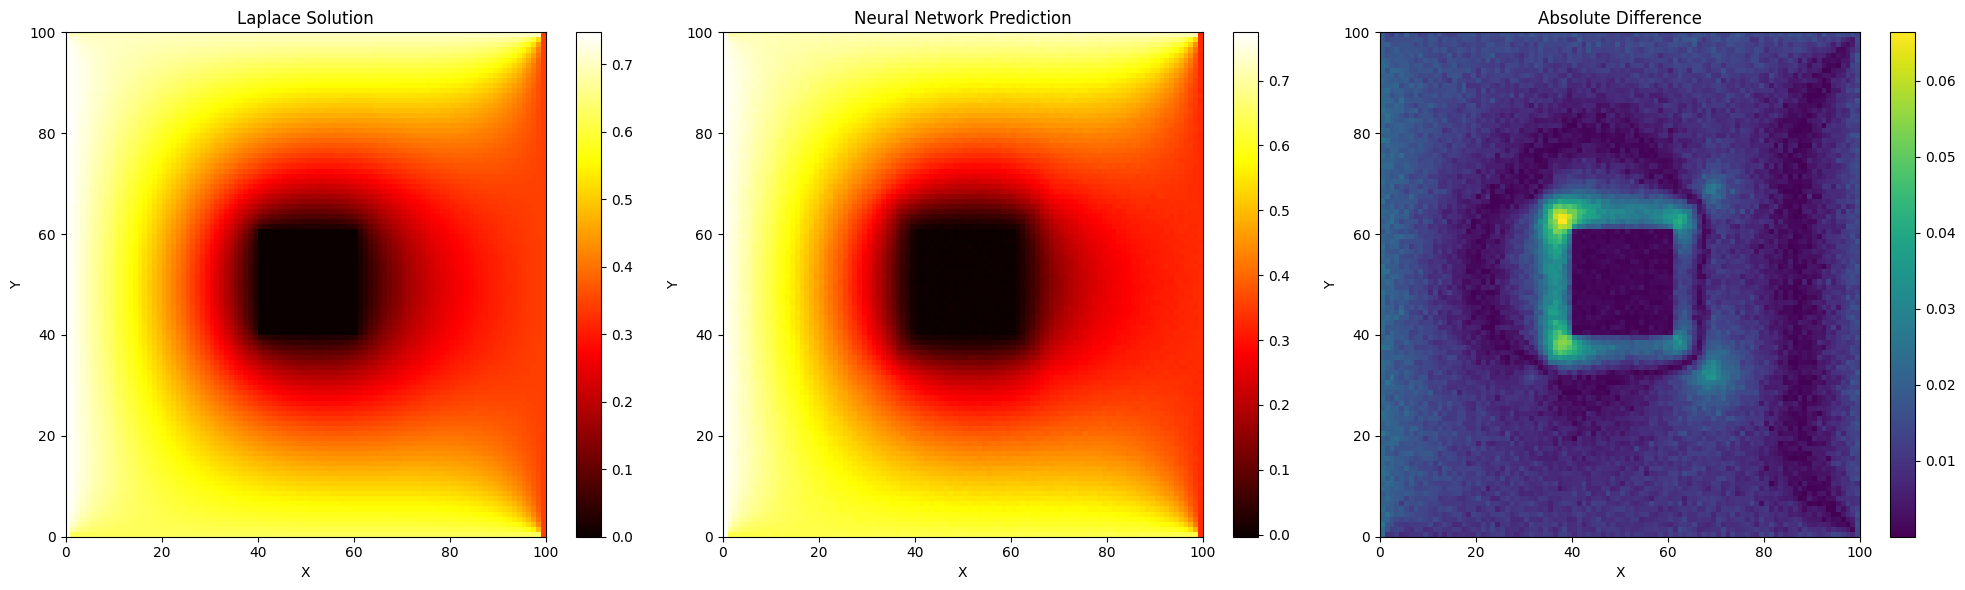

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Mean Squared Error between Laplace solution and neural network prediction: 6.3762e-05


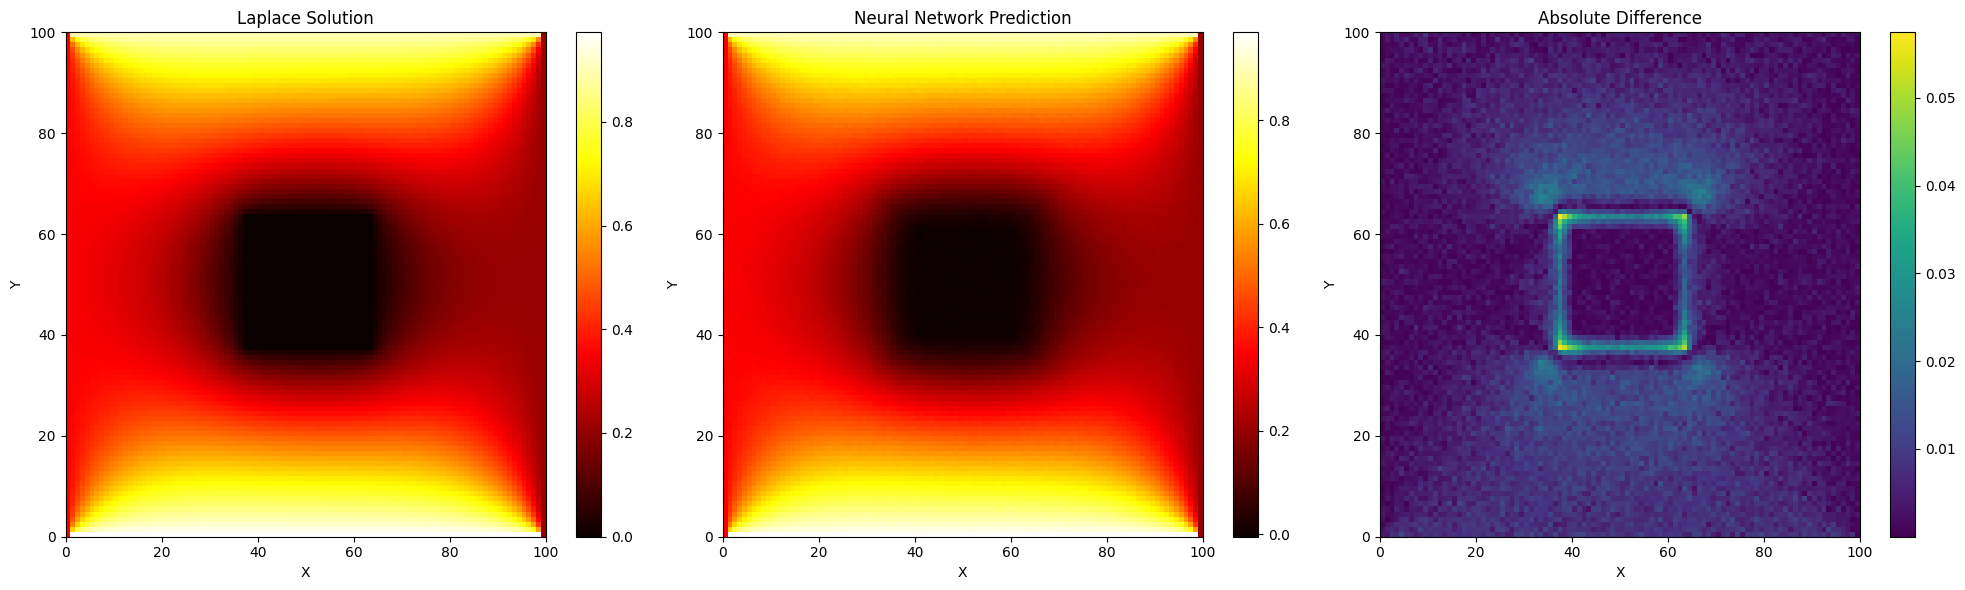

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Mean Squared Error between Laplace solution and neural network prediction: 7.1046e-05


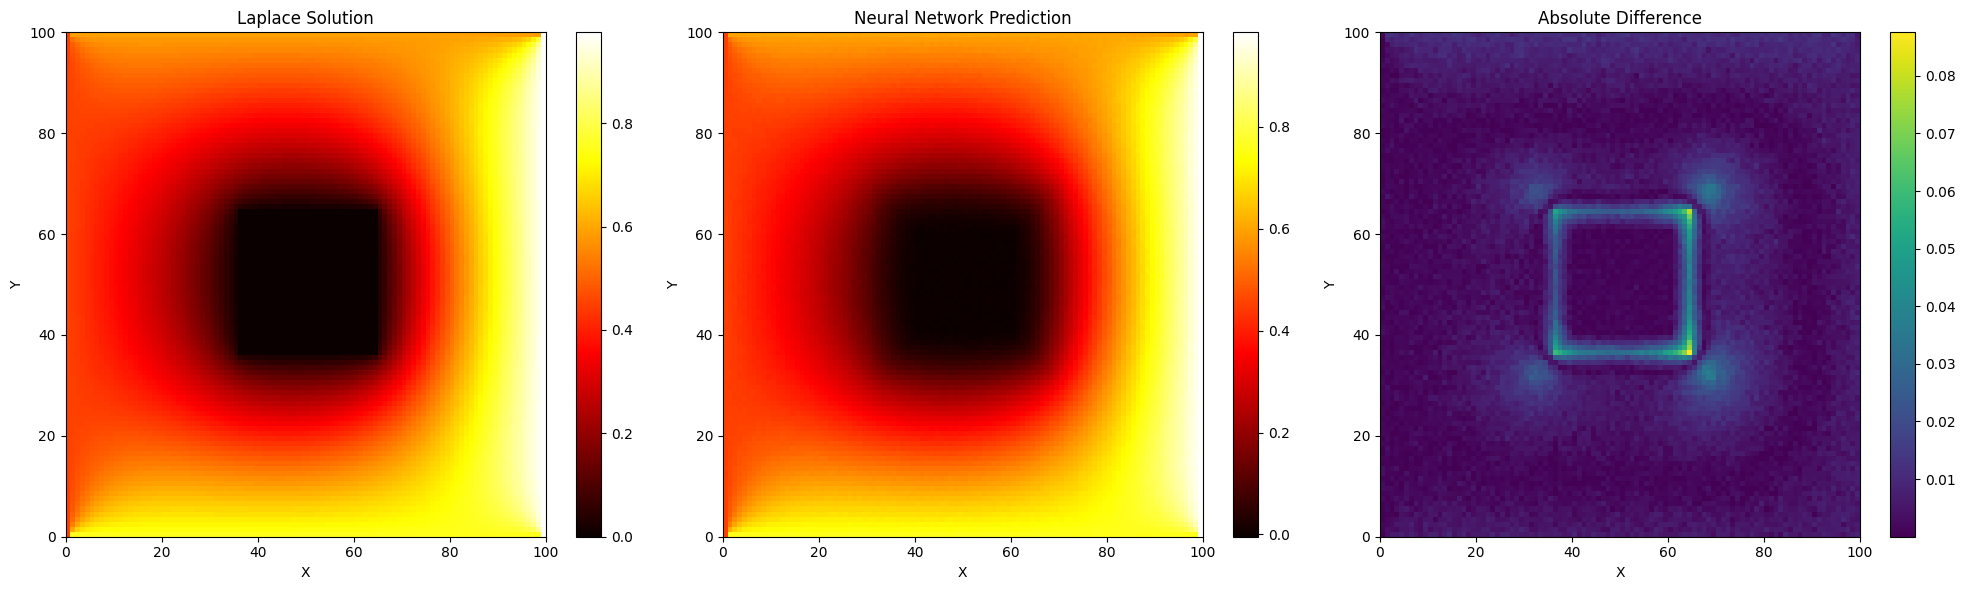

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mean Squared Error between Laplace solution and neural network prediction: 3.0111e-05


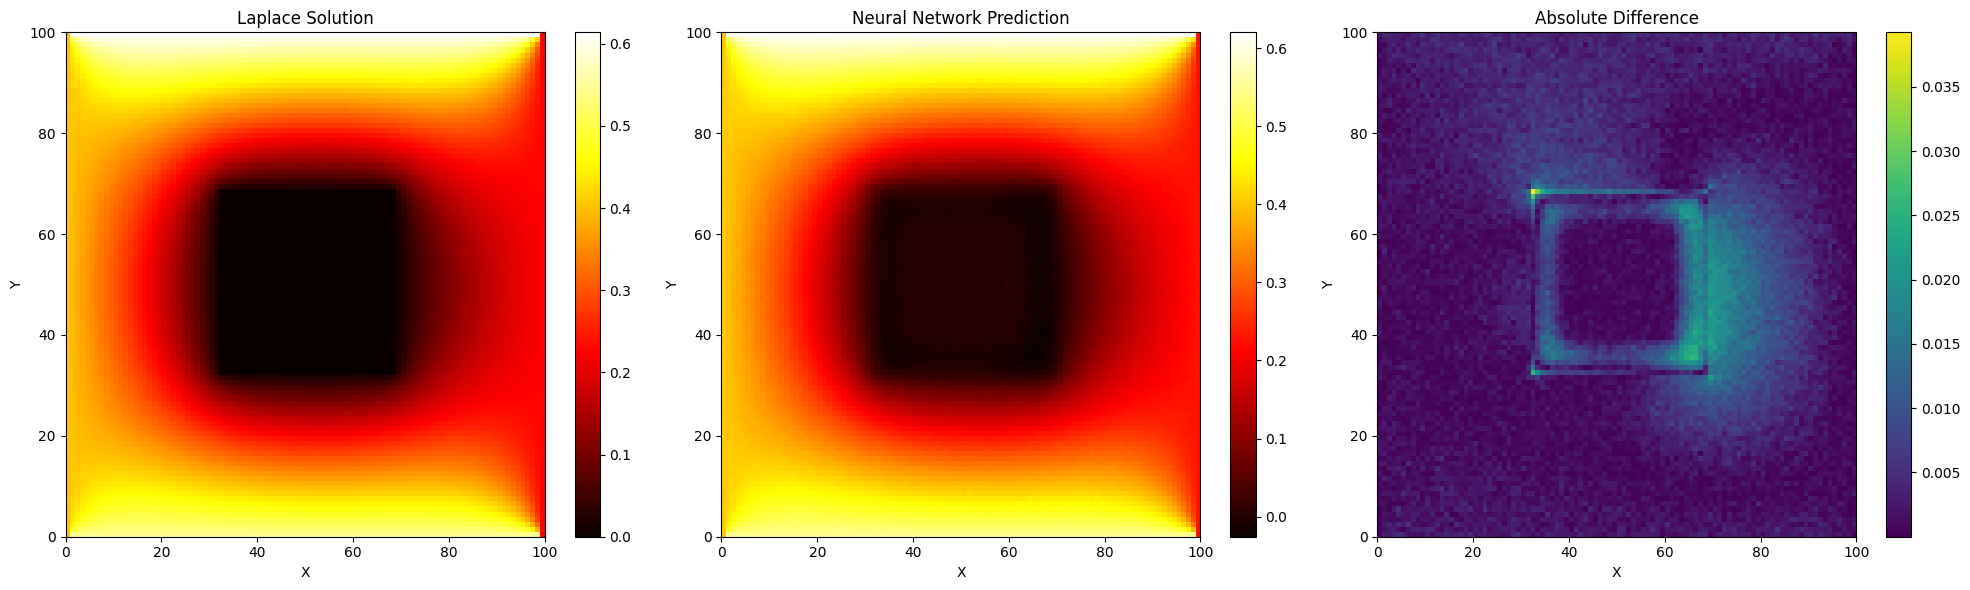

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Mean Squared Error between Laplace solution and neural network prediction: 2.5887e-05


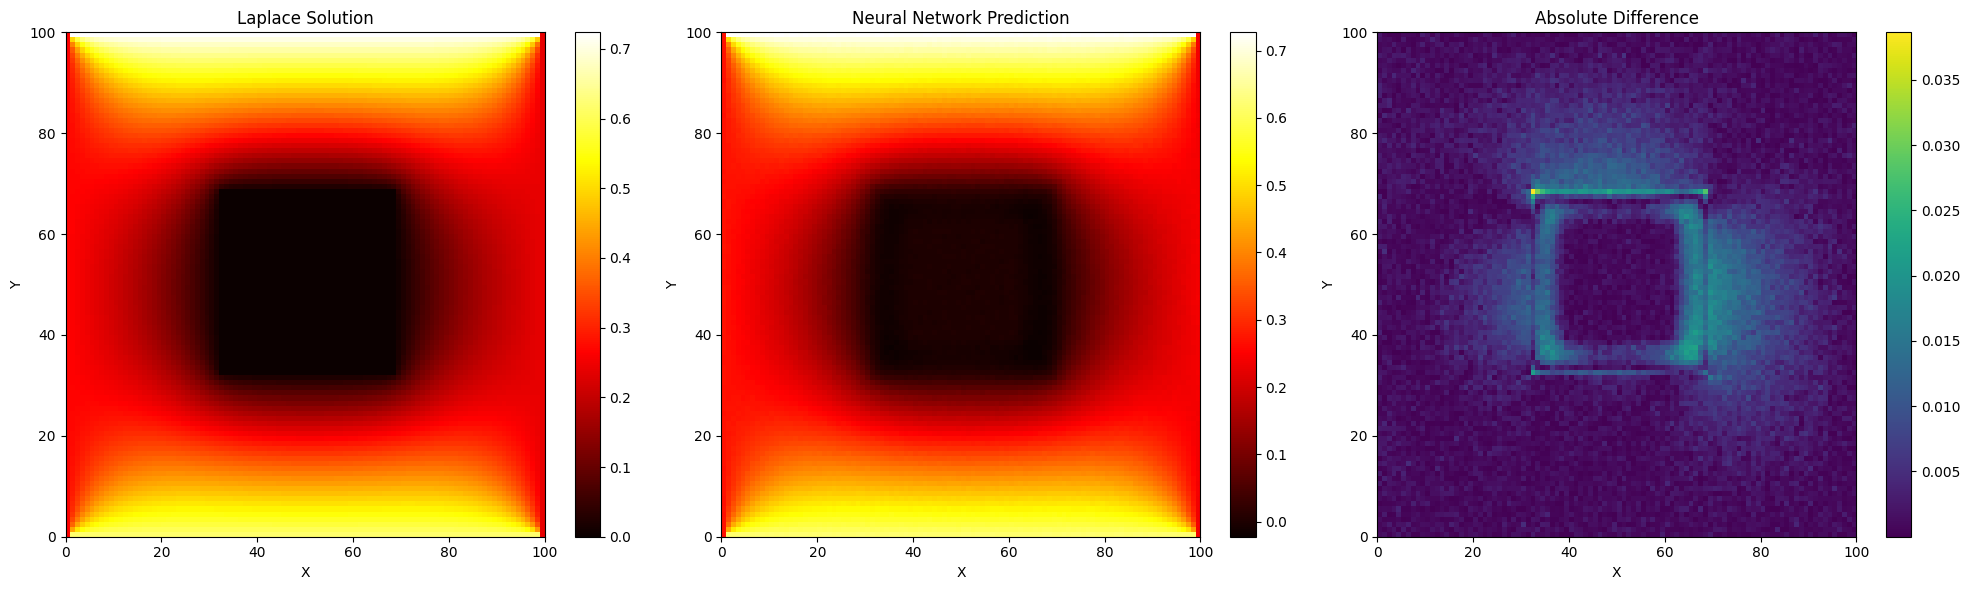

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Mean Squared Error between Laplace solution and neural network prediction: 2.5866e-05


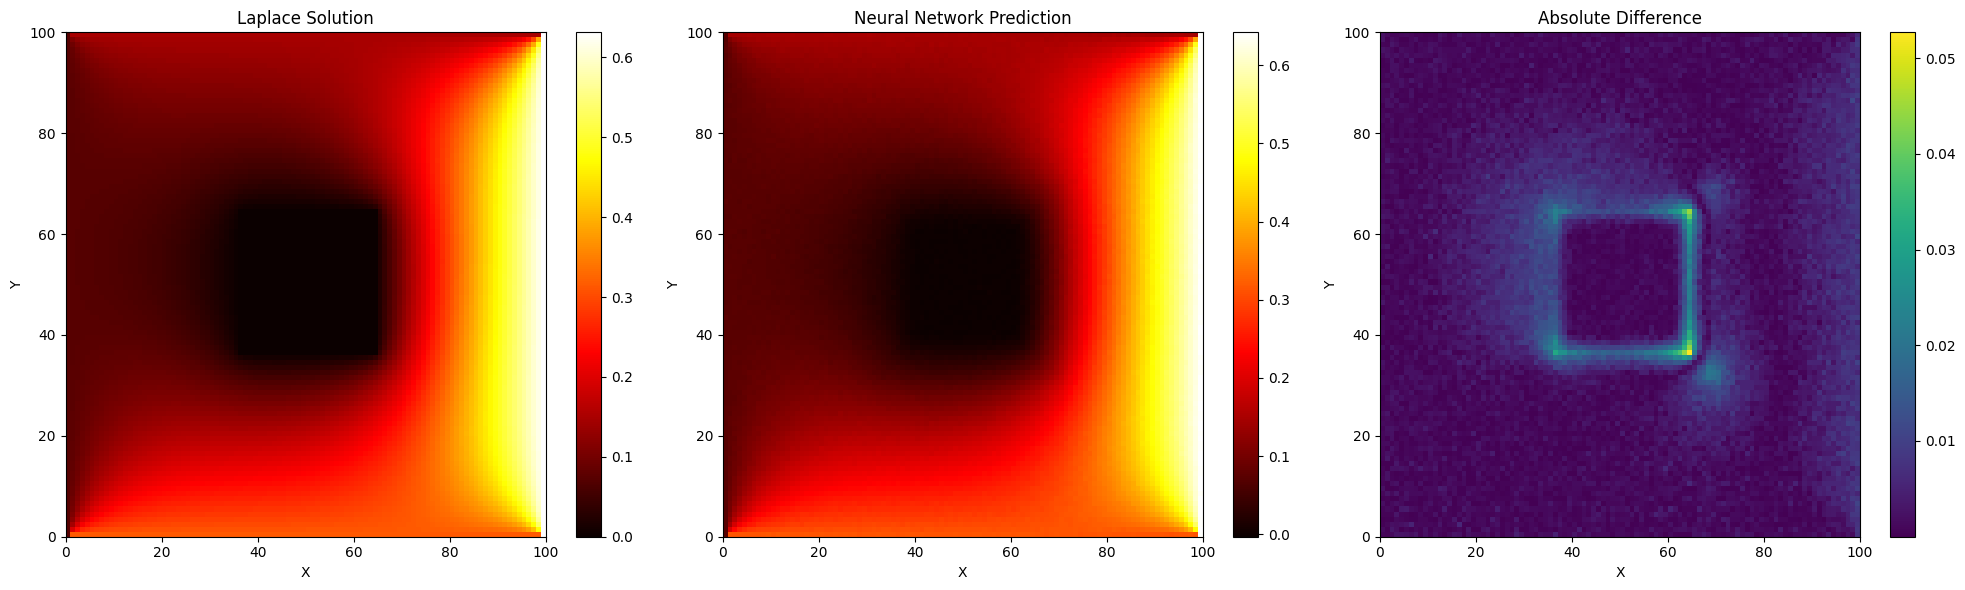

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Mean Squared Error between Laplace solution and neural network prediction: 4.3006e-05


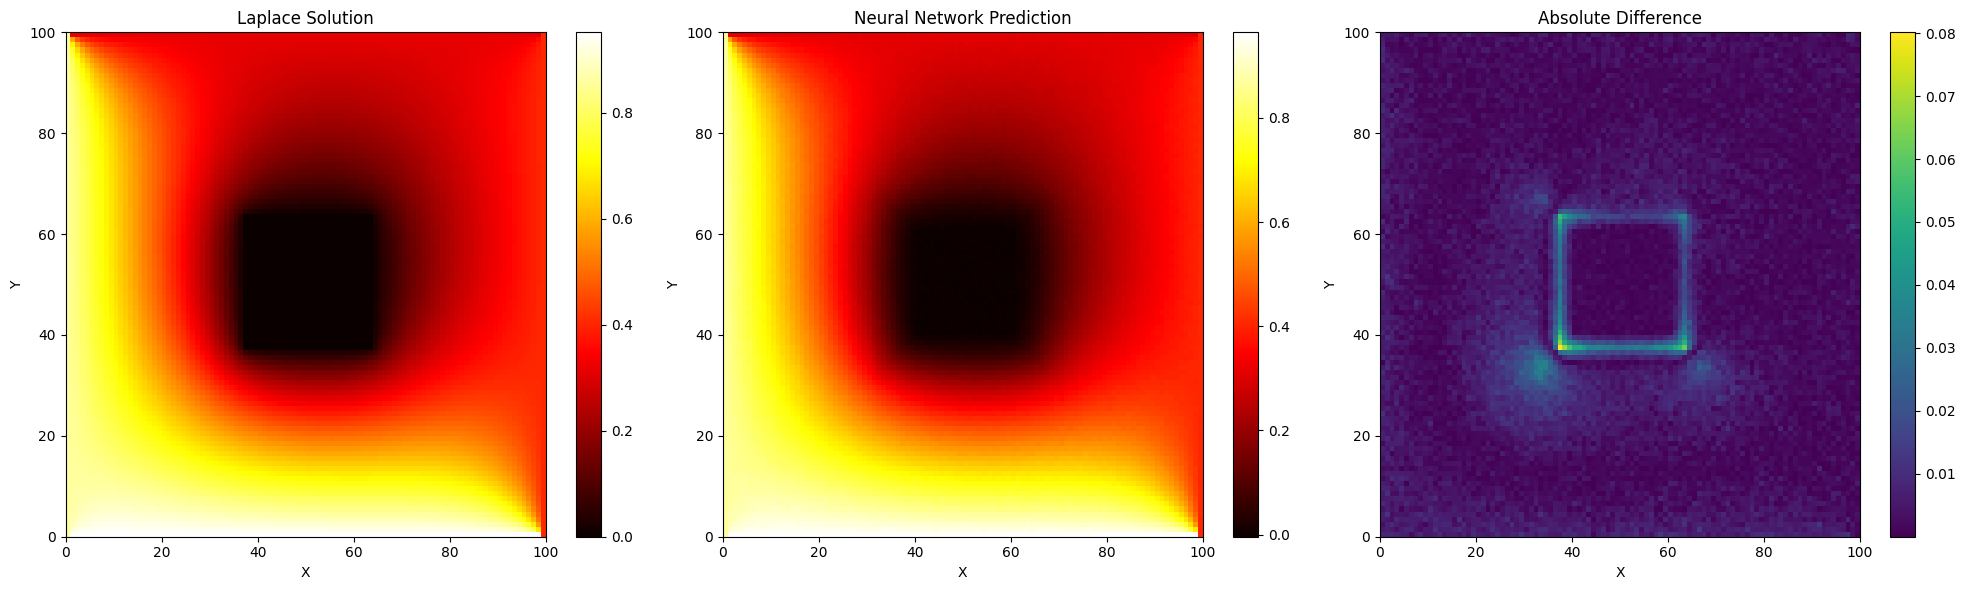

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Mean Squared Error between Laplace solution and neural network prediction: 2.9023e-05


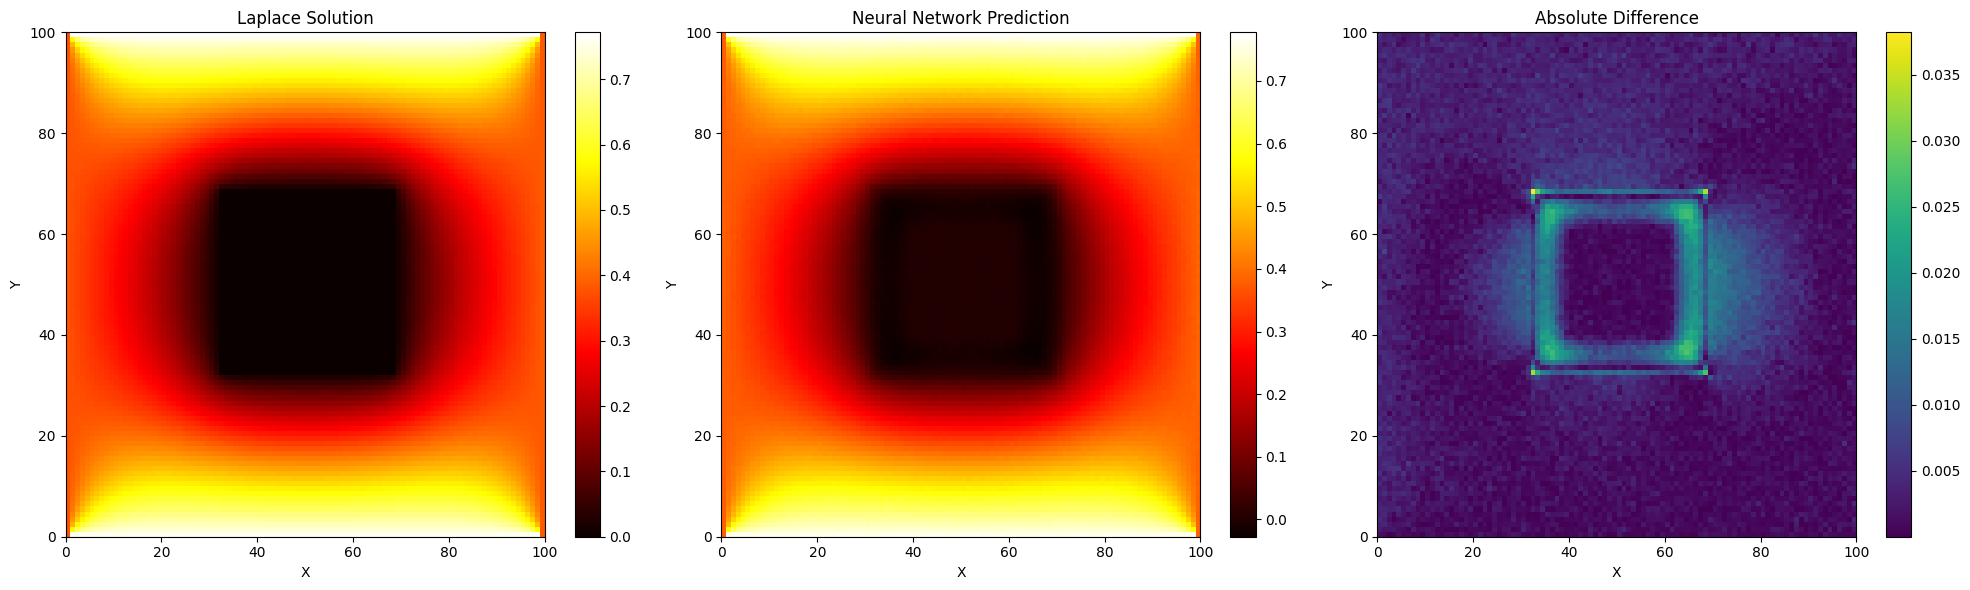

In [41]:
from sklearn.metrics import mean_squared_error

for its in range(10):

  # Test the prediction for a random boundary condition
  boundary_conditions = np.array([np.random.uniform(0, 1),
                                  np.random.uniform(0, 1),
                                  np.random.uniform(0, 1),
                                  np.random.uniform(0, 1),
                                  int(np.random.uniform(10, 20))]).reshape(1, 5)

  pred_image = network.predict(boundary_conditions)[0]

  u = np.zeros((ny, nx))  # Initial guess

  t, b, l, r, hole_size = boundary_conditions[0]

  # Apply boundary conditions (Dirichlet)
  u[0, :] = t  # Top boundary
  u[-1, :] = b  # Bottom boundary
  u[:, 0] = l  # Left boundary
  u[:, -1] = r  # Right boundary

  # Solve the Laplace equation using the Jacobi method
  laplace_solution = laplace_2d_converge(u, nx, ny, hole_size, maxiter=100000, tol=1e-6)

  # Calculate the Mean Squared Error (MSE) between the two solutions
  mse = mean_squared_error(laplace_solution.flatten(), pred_image.flatten())
  print(f"Mean Squared Error between Laplace solution and neural network prediction: {mse:.4e}")

  # Visualize both solutions to compare
  fig, ax = plt.subplots(1, 3, figsize=(20, 6))

  # Plot the Laplace solution
  c0 = ax[0].pcolormesh(laplace_solution, cmap='hot')
  ax[0].set_title('Laplace Solution')
  ax[0].set_xlabel('X')
  ax[0].set_ylabel('Y')
  fig.colorbar(c0, ax=ax[0], orientation='vertical')

  # Plot the neural network prediction
  c1 = ax[1].pcolormesh(pred_image, cmap='hot')
  ax[1].set_title('Neural Network Prediction')
  ax[1].set_xlabel('X')
  ax[1].set_ylabel('Y')
  fig.colorbar(c1, ax=ax[1], orientation='vertical')

  # Optionally, plot the absolute difference between the two solutions
  c2 = ax[2].pcolormesh(np.abs(laplace_solution - pred_image), cmap='viridis')
  ax[2].set_title('Absolute Difference')
  ax[2].set_xlabel('X')
  ax[2].set_ylabel('Y')
  fig.colorbar(c2, ax=ax[2], orientation='vertical')

  plt.tight_layout()
  plt.show()